# Regret Heuristics

## Imports

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns
import random
random.seed(42)
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Constants Declarations

In [2]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

## Read Data

In [3]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

x     y   val
0    1355  1796   496
1    2524   387   414
2    2769   430   500
3    3131  1199  1133
4     661    87   903
..    ...   ...   ...
195   189  1151  1145
196  3688   759   727
197   973   984  1637
198   910  1383  1255
199   262  1669  1307

[200 rows x 3 columns]

## Utils

In [4]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [5]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [6]:
def find_second_node_closest(start_node, matrix, weights):
    '''
    Finds the second node for the TSP cycle using a greedy approach, selecting the node closest
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    second_node = np.argmin(distance_matrix[:, start_node] + weights)
    return second_node

def find_second_node_regret(start_node, non_cycle_nodes, matrix, weights):
    '''
    Finds the second node using a regret-based heuristic. The regret is calculated as the difference 
    between the closest and second closest nodes, and the node with the highest regret is selected.

    Parameters:
    start_node: int, the index of the node from which the cycle starts.
    non_cycle_nodes: set of remaining nodes that are not yet in the cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    best_node: int, the index of the selected second node based on the regret heuristic.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    best_node = None
    best_regret = -np.inf
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        if regret > best_regret:
            best_regret = regret
            best_node = node
    return best_node

def find_third_node(node_1, node_2, matrix, weights):
    '''
    Finds the third node for the TSP cycle by selecting the node that minimizes the total 
    distance from both the first and second nodes, considering node weights.

    Parameters:
    node_1: int, the index of the first node.
    node_2: int, the index of the second node.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    third_node: int, the index of the third node to complete the initial triangle of the cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    third_node = np.argmin(distance_matrix[:, node_1] + distance_matrix[:, node_2] + weights)
    return third_node


def calculate_score_three(solution, matrix, weights):
    '''
    Calculates the score (total distance) for a TSP cycle for the first three nodes. 

    Parameters:
    solution: list of three ints representing the node indices of the current cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    score = 0
    node_1 = solution[0]
    node_2 = solution[1]
    node_3 = solution[2]
    score += matrix[node_1][node_2] + weights[node_1]
    score += matrix[node_2][node_3] + weights[node_2]
    score += matrix[node_3][node_1] + weights[node_3]
    return score

def update_score(solution, score, node, insert_location, matrix, weights):
    '''
    Updates the total score after inserting a node at a specified location in the solution. 

    Parameters:
    solution: List of nodes representing the current cycle.
    score: The current total score (cost) of the cycle before the node is inserted.
    node: int, the node to be inserted into the solution.
    insert_location: int, the index at which the node will be inserted.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score

def find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight):
    '''
    Finds the second node for the TSP cycle using a mix of a weighted greedy and regret approaches
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)

    greedy_scores = []
    ordered_nodes = list(non_cycle_nodes)
    for node in non_cycle_nodes:
        greedy_score = distance_matrix[start_node][node] + weights[node]
        greedy_scores.append(greedy_score)

    regret_scores = []
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        regret_scores.append(regret)

    greedy_scores = np.array(greedy_scores)
    regret_scores = np.array(regret_scores)
    total_scores = ((1 + regret_weight) * greedy_score) + (regret_weight * regret_scores)
    total_scores, ordered_nodes = zip(*sorted(zip(total_scores, ordered_nodes)))
    return ordered_nodes[0]

In [7]:
def random_solution(distance_matrix, weights, start_node):
    '''
    Returns a random solution to the TSP problem based on the provided distance matrix.

    Parameters:
    distance_matrix: numpy.array containing distances between the nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''

    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [8]:
def nearest_neighbor_all(distance_matrix, weights, start_node):
    '''
    Greedy solution to the TSP problem that selects the closest node from all previously selected.

    Parameters:
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''
    d_matrix = np.copy(distance_matrix)
    d_matrix = d_matrix.astype(np.float64)
    np.fill_diagonal(d_matrix, np.inf)
    num_nodes = d_matrix.shape[0]

    d_matrix[start_node] = np.inf
    
    solution = [start_node]

    i = 1
    while i < num_nodes//2:
        j = 0
        best_found = np.inf
        insert_node_idx = None
        insert_node_nearest = None    

        while j < i:
            tested_node = solution[j]

            nearest_node = np.argmin(d_matrix[:, tested_node] + weights)
            min_cost = d_matrix[:, tested_node][nearest_node] + weights[nearest_node]

            if min_cost < best_found:
                best_found = min_cost
                insert_node_idx = j+1
                insert_node_nearest = nearest_node            

            j += 1

        d_matrix[insert_node_nearest] = np.inf
        solution.insert(insert_node_idx, insert_node_nearest)

        i += 1

    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [9]:
def greedy_regret_cycle(matrix, weights, start_node):
    '''
    Implements a greedy regret cycle algorithm with regret to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    solution = [start_node]
    non_cycle_nodes = set([i for i in range(len(weights))])
    non_cycle_nodes.remove(start_node)
    num_iterations = int((len(weights) // 2) - 3)
    second_node = find_second_node_closest(start_node, matrix, weights)
    #second_node = find_second_node_regret(start_node, non_cycle_nodes, matrix, weights)
    solution.append(second_node)
    non_cycle_nodes.remove(second_node)
    third_node = find_third_node(start_node, second_node, matrix, weights)
    solution.append(third_node)
    non_cycle_nodes.remove(third_node)
    score = calculate_score_three(solution, matrix, weights)

    for i in range(num_iterations):
        best_regret = -np.inf
        best_node = None
        best_location = None
        best_score = None
        for node in non_cycle_nodes:
            scores = []
            score_locations = []
            for insert_location in range(len(solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            scores = list(scores)
            score_locations = list(score_locations)
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            if regret > best_regret:
                best_regret = regret
                best_node = node
                best_location = regret_location
                best_score = scores[0]
        solution.insert(best_location, best_node)
        score = best_score
        non_cycle_nodes.remove(best_node)
    return solution, score

In [10]:
def greedy_regret_cycle_weighted(matrix, weights, start_node, regret_weight=-0.5):
    '''
    Implements a weighted greedy cycle algorithm with regret to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    solution = [start_node]
    non_cycle_nodes = set([i for i in range(len(weights))])
    non_cycle_nodes.remove(start_node)
    num_iterations = int((len(weights) // 2) - 3)
    second_node = find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight)
    #second_node = find_second_node_closest(start_node, matrix, weights)
    solution.append(second_node)
    non_cycle_nodes.remove(second_node)
    third_node = find_third_node(start_node, second_node, matrix, weights)
    solution.append(third_node)
    non_cycle_nodes.remove(third_node)
    score = calculate_score_three(solution, matrix, weights)

    for i in range(num_iterations):
        best_weighted_score = np.inf
        best_score = None
        best_node = None
        best_location = None
        for node in non_cycle_nodes:
            score_locations = []
            scores = []
            for insert_location in range(len(solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            score_difference = scores[0] - score
            weghted_score = ((1 + regret_weight) * score_difference) + (regret_weight * regret)
            if weghted_score < best_weighted_score:
                best_weighted_score = weghted_score
                best_node = node
                best_location = regret_location
                best_score = scores[0]
        solution.insert(best_location, best_node)
        score = best_score
        non_cycle_nodes.remove(best_node)
    return solution, score

In [11]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

0     1     2     3     4     5     6     7     8     9    ...   190  \
0       0  1831  1966  1874  1845  1097  1658  2297  2193  1364  ...  1977   
1    1831     0   249  1014  1887  1985   802  1872  1270  1027  ...  2173   
2    1966   249     0   850  2136  2209  1050  1698  1066   981  ...  2421   
3    1874  1014   850     0  2709  2513  1715   858   344   512  ...  2976   
4    1845  1887  2136  2709     0   888  1091  3487  3036  2396  ...   288   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
195  1333  2457  2679  2942  1164   473  1834  3537  3286  2486  ...  1087   
196  2553  1222   976   710  3101  3068  2023  1124   517  1212  ...  3384   
197   897  1662  1880  2169   950   345  1113  2824  2513  1741  ...  1085   
198   607  1897  2089  2229  1320   497  1462  2785  2569  1752  ...  1409   
199  1100  2600  2796  2907  1632   785  2100  3395  3242  2414  ...  1593   

      191   192   193   194   195   196   197   198   199  
0     746  1414   993  1527  1333  2553   897   607  1100  
1    2104  2213  2215  1016  2457  1222  1662  1897  2600  
2    2301  2447  2426  1264  2679   976  1880  2089  2796  
3    2442  2809  2632  1861  2942   710  2169  2229  2907  
4    1352   780  1214   874  1164  3101   950  1320  1632  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
195   587   384   342  1587     0  3521   802   757   523  
196  3063  3338  3231  2227  3521     0  2724  2847  3545  
197   529   649   563   890   802  2724     0   404   987  
198   216   807   419  1260   757  2847   404     0   708  
199   496   871   448  1872   523  3545   987   708     0  

[200 rows x 200 columns]

In [12]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

## Greedy Local Search

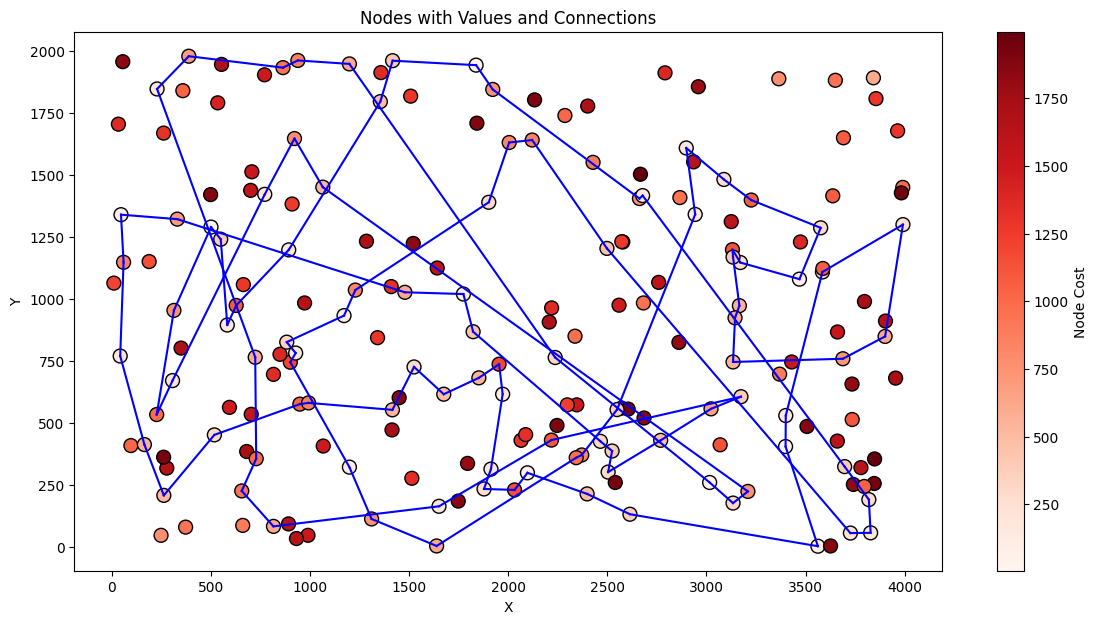

Acheived Total Score: 87896


In [13]:
def update_score_inner(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    if int(abs(cycle_position - any_node_position)) > 1 and int(abs(cycle_position - any_node_position)) < 99:
        node_1 = solution[cycle_position]
        node_2 = solution[any_node_position]
        node_before_1 = solution[cycle_position-1]
        if cycle_position + 1 == num_cycle_nodes:
            node_after_1 = solution[0]
        else:
            node_after_1 = solution[cycle_position+1]

        node_before_2 = solution[any_node_position-1]
        if any_node_position + 1 == num_cycle_nodes:
            node_after_2 = solution[0]
        else:
            node_after_2 = solution[any_node_position+1]

        temp_score -= distance_matrix[node_1][node_before_1]
        temp_score -= distance_matrix[node_1][node_after_1]
        temp_score -= distance_matrix[node_2][node_before_2]
        temp_score -= distance_matrix[node_2][node_after_2]
        temp_score += distance_matrix[node_1][node_before_2]
        temp_score += distance_matrix[node_1][node_after_2]
        temp_score += distance_matrix[node_2][node_before_1]
        temp_score += distance_matrix[node_2][node_after_1]
    else:
        if cycle_position < any_node_position:
            cycle_position, any_node_position = any_node_position, cycle_position
        node_1 = solution[cycle_position]
        node_2 = solution[any_node_position]
        if cycle_position + 1 == num_cycle_nodes and any_node_position + 2 == num_cycle_nodes:
            node_after_1 = solution[0]
        elif cycle_position + 1 == num_cycle_nodes and any_node_position == 0:
            node_after_1 = solution[cycle_position - 1]
        else:
            node_after_1 = solution[cycle_position + 1]
        
        if cycle_position + 1 == num_cycle_nodes and any_node_position == 0:
            node_before_2 = solution[any_node_position + 1]
        else:
            node_before_2 = solution[any_node_position - 1]
        temp_score -= distance_matrix[node_1][node_after_1]
        temp_score -= distance_matrix[node_2][node_before_2]
        temp_score += distance_matrix[node_1][node_before_2]
        temp_score += distance_matrix[node_2][node_after_1]
    return temp_score


def node_inter_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_inner(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    if temp_score < score:
        solution[cycle_position], solution[any_node_position] = solution[any_node_position], solution[cycle_position]
        score = temp_score
        improvement = True
    return score, improvement, solution

def update_score_intra(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position-1]
    if cycle_position + 1 == num_cycle_nodes:
        node_after = solution[0]
    else:
        node_after = solution[cycle_position+1]
    temp_score -= distance_matrix[node_1][node_before]
    temp_score -= distance_matrix[node_1][node_after]
    temp_score -= weights[node_1]
    temp_score += distance_matrix[node_2][node_before]
    temp_score += distance_matrix[node_2][node_after]
    temp_score += weights[node_2]
    return temp_score

def node_intra_change(score, improvement, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    temp_score = score
    relative_node_position = any_node_position - num_cycle_nodes
    temp_score = update_score_intra(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
    if temp_score < score:
        solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
        score = temp_score
        improvement = True
    return score, improvement, solution

def greedy_local_search(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    num_cycle_nodes = len(solution)
    moves = []
    for cycle_position in cycle_positions:
        for any_node in all_node_positions:
            if cycle_position != any_node:
                moves.append((cycle_position, any_node))
    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                score, improvement, solution = node_intra_change(score, improvement, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            else:
                score, improvement, solution = node_inter_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            if improvement:
                break
    return solution, score

solution, score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = greedy_local_search(solution, score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Steepest Local Search

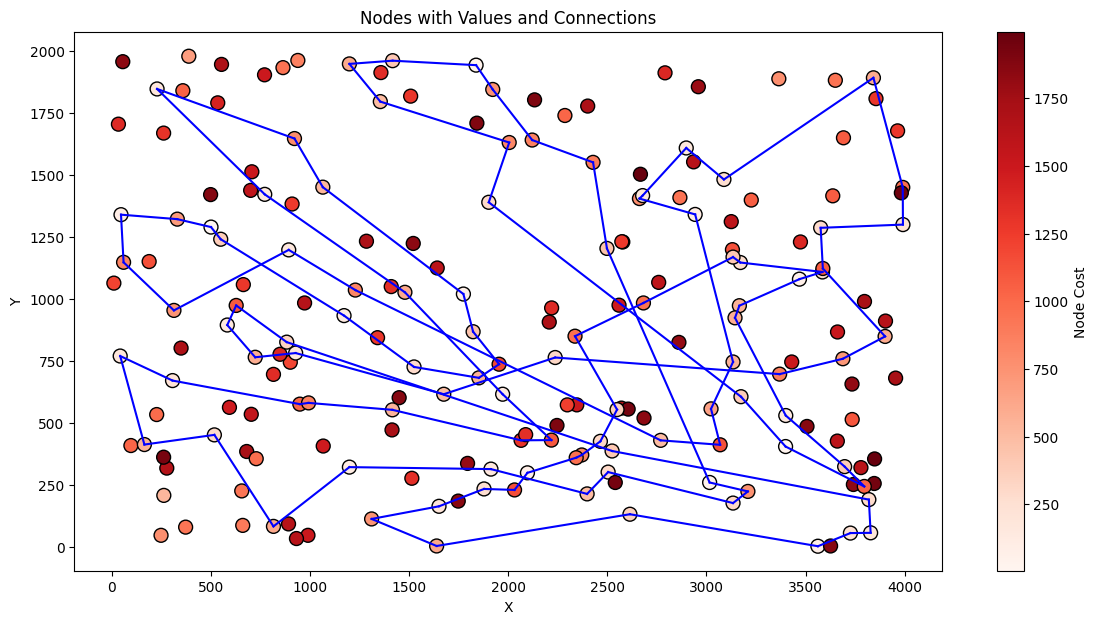

Acheived Total Score: 90139


In [14]:
def node_inter_change_steepest(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_inner(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    solution[cycle_position], solution[any_node_position] = solution[any_node_position], solution[cycle_position]
    return temp_score, solution

def node_intra_change_steepest(score, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    temp_score = score
    relative_node_position = any_node_position - num_cycle_nodes
    temp_score = update_score_intra(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return temp_score, solution, remaining_nodes

def steepest_local_search(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    num_cycle_nodes = len(solution)
    moves = []
    for cycle_position in cycle_positions:
        for any_node in all_node_positions:
            if cycle_position != any_node:
                moves.append((cycle_position, any_node))
    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        best_score = np.inf
        best_solution = None
        best_remaining_nodes = remaining_nodes.copy()
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                temp_score, temp_solution, temp_remaining_nodes = node_intra_change_steepest(score, solution.copy(), cycle_position, any_node_position, remaining_nodes.copy(), num_cycle_nodes, distance_matrix, weights)
            else:
                temp_score = score
                temp_solution = solution.copy()
                temp_score, temp_solution = node_inter_change_steepest(score, solution.copy(), cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
                temp_remaining_nodes = remaining_nodes.copy()
            if temp_score < best_score:
                best_score = temp_score
                best_solution = temp_solution.copy()
                best_remaining_nodes = temp_remaining_nodes.copy()
        if best_score < score:
            score = best_score
            improvement = True
            solution = best_solution.copy()
            remaining_nodes = best_remaining_nodes.copy()
    return solution, score

solution, score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = steepest_local_search(solution, score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Experiments

In [15]:
def test_algorithm(algorithm, distance_matrix, weights, local_algorithm = None):
    '''
    Tests chosen algorithm for each node.

    Parameters:
    local_algorithm: function of the local search
    algorithm: Function to test
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    num_runs: integer, number of tests per node (default: 200)
    '''
    all_nodes = [i for i in range(len(weights))]
    results = {}
    solutions = {}
    times = []
    for node in all_nodes:
        solution, score = algorithm(distance_matrix, weights, node)
        if local_algorithm is not None:
            start_time = time.time()
            solution, score = local_algorithm(solution, score, distance_matrix, weights)
            end_time = time.time()
            times.append(end_time - start_time)
        solutions[node] = solution
        results[node] = score
    return solutions, results, times

In [16]:
del df
del weights
del distance_matrix

### Instance A

In [17]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix_A = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()

In [15]:
random_greedy_local_solution_A, random_greedy_local_result_A = test_algorithm(random_solution, distance_matrix_A, weights_A, local_algorithm = greedy_local_search)

In [16]:
random_steepest_solution_A, random_steepest_result_A = test_algorithm(random_solution, distance_matrix_A, weights_A, local_algorithm = steepest_local_search)

In [ ]:
weighted_greedy_local_solution_A, weighted_greedy_local_result_A = test_algorithm(greedy_regret_cycle_weighted, distance_matrix_A, weights_A, local_algorithm = greedy_local_search)

In [ ]:
weighted_steepest_solution_A, weighted_steepest_result_A = test_algorithm(greedy_regret_cycle_weighted, distance_matrix_A, weights_A, local_algorithm = steepest_local_search)

### Instance B

In [17]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix_B = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()

In [18]:
random_greedy_local_solution_B, random_greedy_local_result_B = test_algorithm(random_solution, distance_matrix_B, weights_B, local_algorithm = greedy_local_search)

In [19]:
random_steepest_solution_B, random_steepest_result_B = test_algorithm(random_solution, distance_matrix_B, weights_B, local_algorithm = steepest_local_search)

In [ ]:
weighted_greedy_local_solution_B, weighted_greedy_local_result_B = test_algorithm(greedy_regret_cycle_weighted, distance_matrix_B, weights_B, local_algorithm = greedy_local_search)

In [ ]:
weighted_steepest_solution_B, weighted_steepest_result_B = test_algorithm(greedy_regret_cycle_weighted, distance_matrix_B, weights_B, local_algorithm = steepest_local_search)

## Results - Instance A

In [20]:
def plot_nodes_with_lines_and_score(df, score, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = f'Nodes with Color-Scaled Values, Score: {score}' if connections is None else f'Nodes with Color-Scaled Values, Score: {score}'
    plt.title(title)
    plt.grid(False)
    plt.show()

def plot_score_distribution(score_dict, label):
    all_scores = []
    for key in score_dict.keys():
        for item in score_dict[key]:
            all_scores.append(item)
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores Across All Nodes For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_score_distribution_not_random(score_dict, label):
    all_scores = []
    for key in score_dict.keys():
        item = score_dict[key]
        all_scores.append(item)
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores Across All Nodes For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_distribution_node(score_dict, node, label):
    all_scores = score_dict[node]
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores For {node} Node For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_score_distributions(score_dict_1, score_dict_2, labels):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(all_scores_1, label=labels[0], color='black', linewidth=2)
    sns.kdeplot(all_scores_2, label=labels[1], color='red', linewidth=2)
    plt.xscale('log')
    
    # Add titles and labels
    plt.title('Continuous Distribution of Scores Across Different Nodes', fontsize=14)
    plt.xlabel('Score Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(loc='upper right')
    plt.show()


def plot_worst_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmax(all_scores)
    best_solution = all_solutions[best_overall]
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_worst_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_results = np.array(results[node])
    best_solution = all_solutions[np.argmax(all_results)]
    plot_nodes_with_lines_and_score(df, all_results[np.argmax(all_results)], best_solution)

def plot_average_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)

    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)
    
def plot_average_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_scores = results[node]
    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)

def plot_best_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmin(all_scores)
    best_solution = all_solutions[best_overall]
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_best_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_results = np.array(results[node])
    best_solution = all_solutions[np.argmin(all_results)]
    plot_nodes_with_lines_and_score(df, all_results[np.argmin(all_results)], best_solution)

def calculate_stats_overall(results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    all_scores = np.array(all_scores)
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation

def calculate_stats_node(results, node):
    all_scores = np.array(results[node])
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation

def summarize_results(results_1, results_2):
    total_results= {}
    comparison_regret = {}
    comparison_weighted = {}

    for node in results_1.keys():
        scores = np.array(results_1[node])
        comparison_regret[node] = {"Best Score:" : np.min(scores),
                            "Worst Score:" : np.max(scores),
                            "Median Score:" : np.median(scores),
                            "Average Score" : np.mean(scores)}
    
    for node in results_2.keys():
        scores = np.array([results_2[node]])
        comparison_weighted[node] = {"Best Score:" : np.min(scores),
                            "Worst Score:" : np.max(scores),
                            "Median Score:" : np.median(scores),
                            "Average Score" : np.mean(scores)}
    
    labels = ["Greedy Regret", "Weighted Greedy"]
    for node in results_1.keys():
        scores_1 = np.array(results_1[node])
        scores_2 = np.array([results_2[node]])

        max_1 = np.max(scores_1)
        max_2 = np.max(scores_2)

        min_1 = np.min(scores_1)
        min_2 = np.min(scores_2)

        avr_1 = np.mean(scores_1)
        avr_2 = np.mean(scores_2)
        
        median_1 = np.median(scores_1)
        median_2 = np.median(scores_2)

        maxs = np.array([max_1, max_2])
        mins = np.array([min_1, min_2])
        means = np.array([avr_1, avr_2])
        medians = np.array([median_1, median_2])
        
        total_results[node] = {"Best Maximum Score" : labels[np.argmin(maxs)],
                               "Best Minimum Score" : labels[np.argmin(mins)],
                               "Best Average Score" : labels[np.argmin(means)],
                               "Best Median Score" : labels[np.argmin(medians)]

        }

    return pd.DataFrame(comparison_regret), pd.DataFrame(comparison_weighted), pd.DataFrame(total_results)

In [21]:
def plot_best_overall_not_random(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmin(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_average_overall_not_random(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)

    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    
    print("___________________________________________________________________")
    print(f"For Node: {median_index}")
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)

def plot_worst_overall_not_random(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmax(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)


def calculate_stats_overall_not_random(results):
    all_scores = []
    for key in results.keys():
        all_scores.append(results[key])
    all_scores = np.array(all_scores)
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation


def plot_node(df, scores, solutions, node):
    score = scores[node]
    connections = solutions[node]
    print(f"Plotting Node: {node}")
    plot_nodes_with_lines_and_score(df, score, connections)

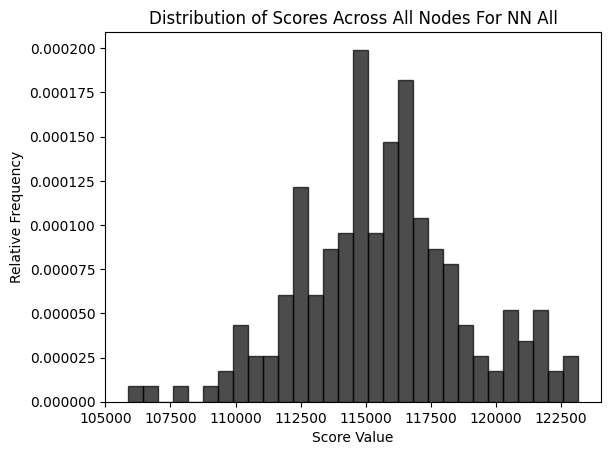

___________________________________________________________________
For Node: 93


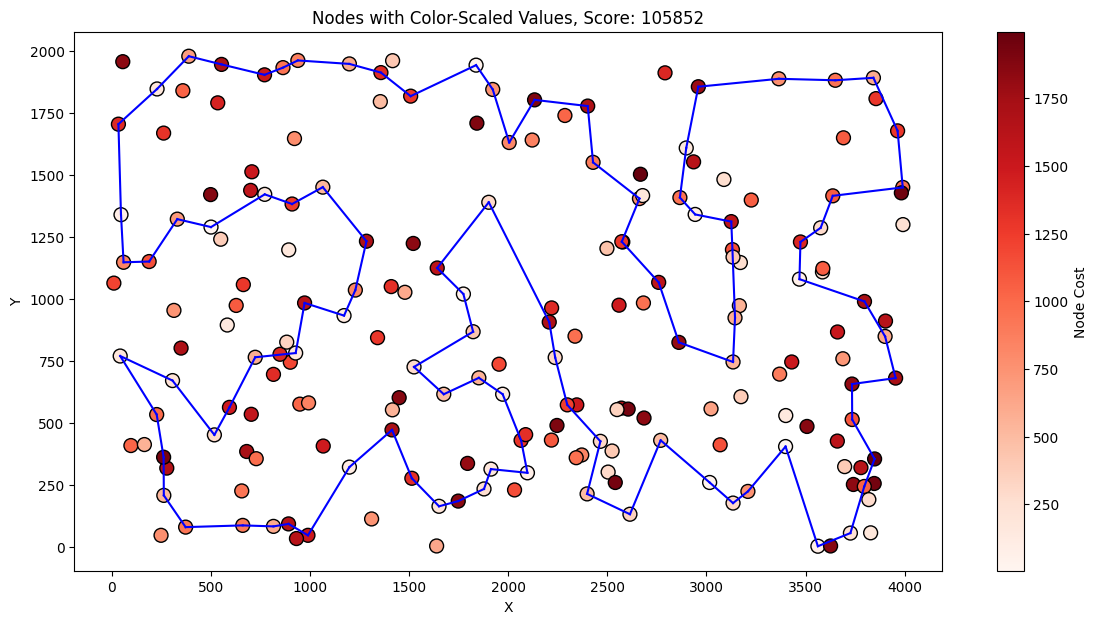

Plotting Node: 0


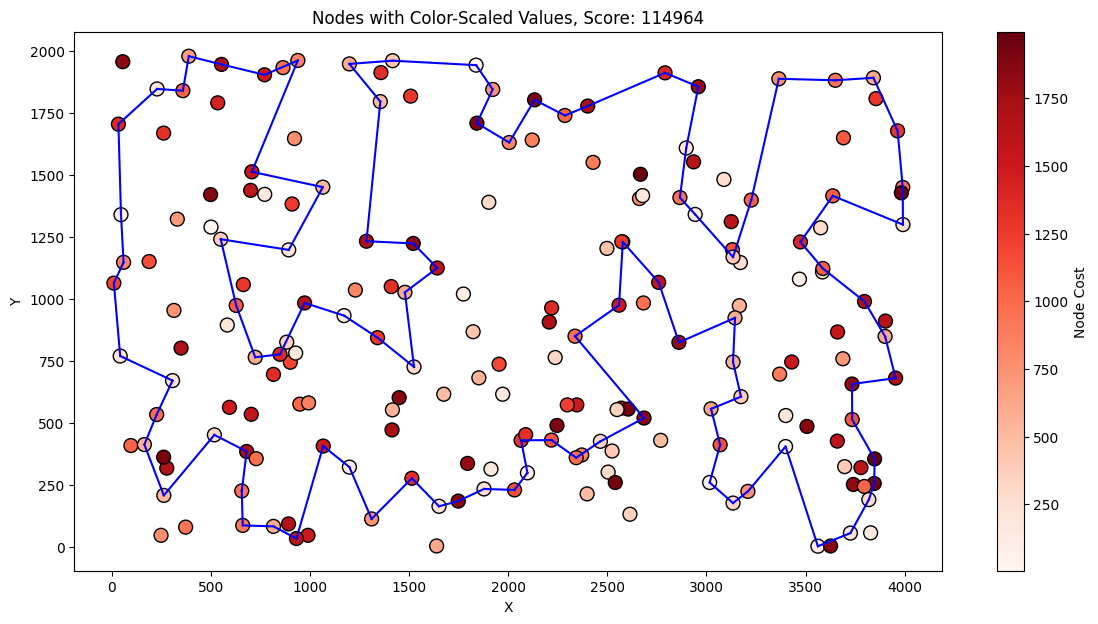

___________________________________________________________________
For Node: 192


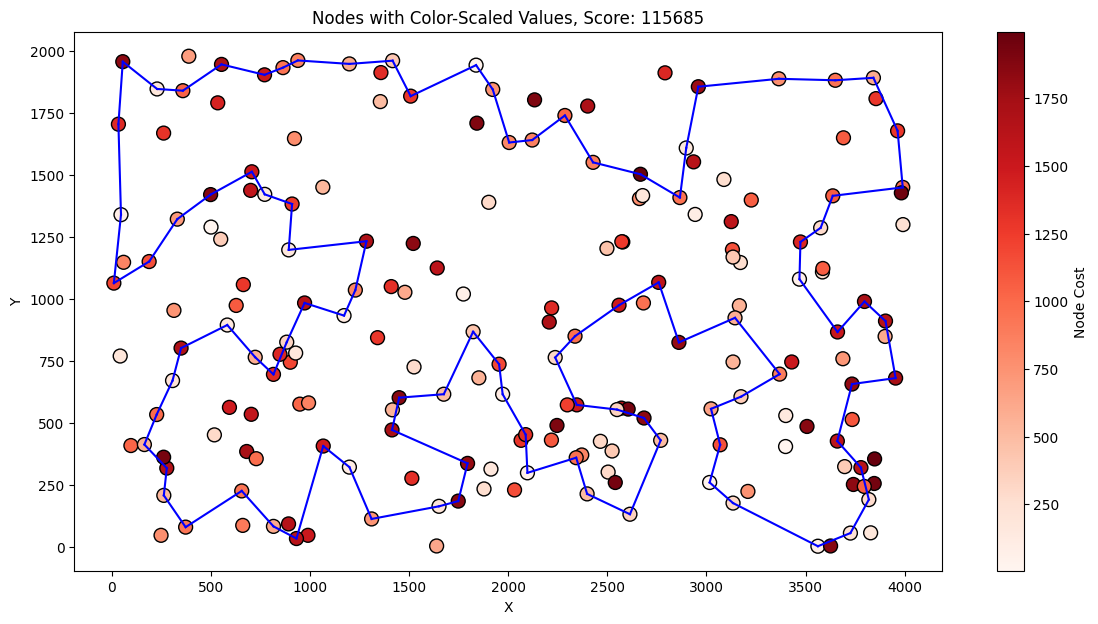

___________________________________________________________________
For Node: 48


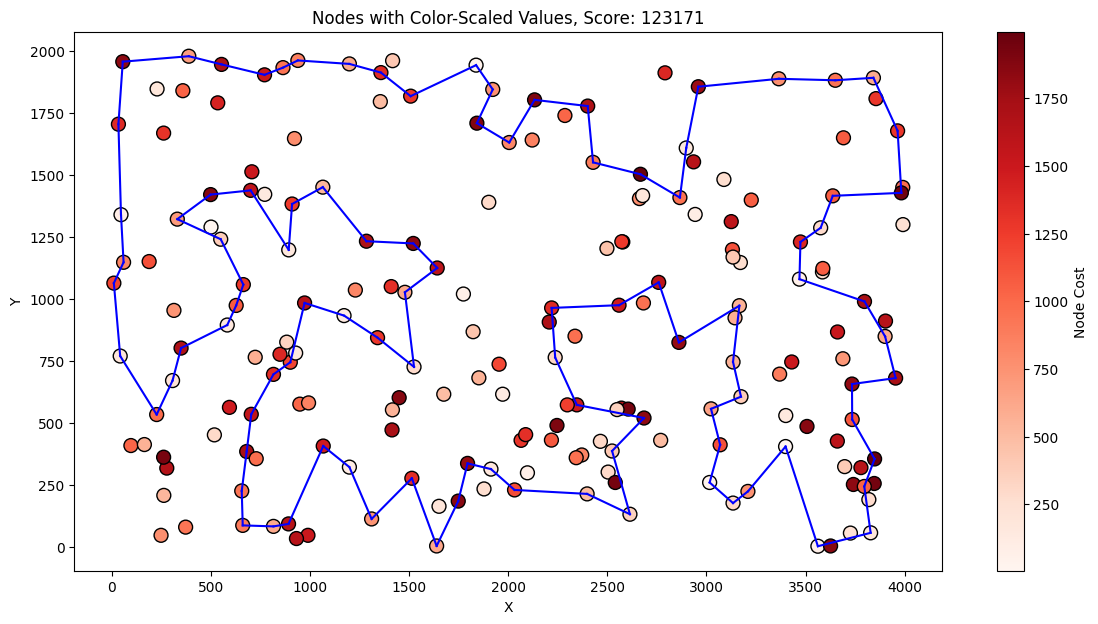

Overall Stats: 
 Minimum: 105852 Maximum: 123171 Median: 115656.0 Mean: 115630.16 Standard Deviation: 3172.720896076426


In [22]:
plot_score_distribution_not_random(greedy_regret_cycle_results_A, label="NN All")
plot_best_overall_not_random(df_A, greedy_regret_cycle_solutions_A, greedy_regret_cycle_results_A)
plot_node(df_A, greedy_regret_cycle_results_A, greedy_regret_cycle_solutions_A, node=0)
plot_average_overall_not_random(df_A, greedy_regret_cycle_solutions_A, greedy_regret_cycle_results_A)
plot_worst_overall_not_random(df_A, greedy_regret_cycle_solutions_A, greedy_regret_cycle_results_A)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(greedy_regret_cycle_results_A)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

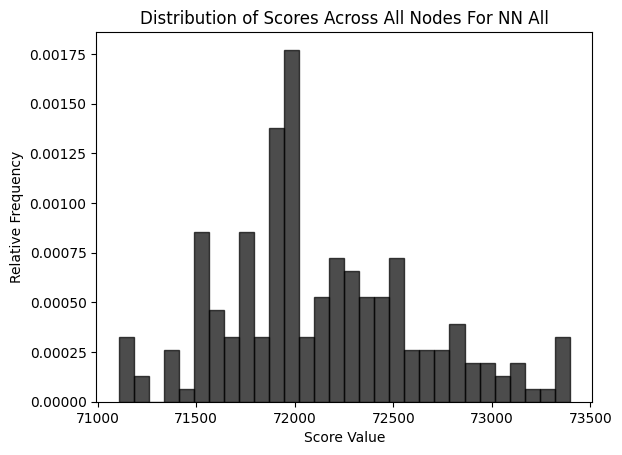

___________________________________________________________________
For Node: 0


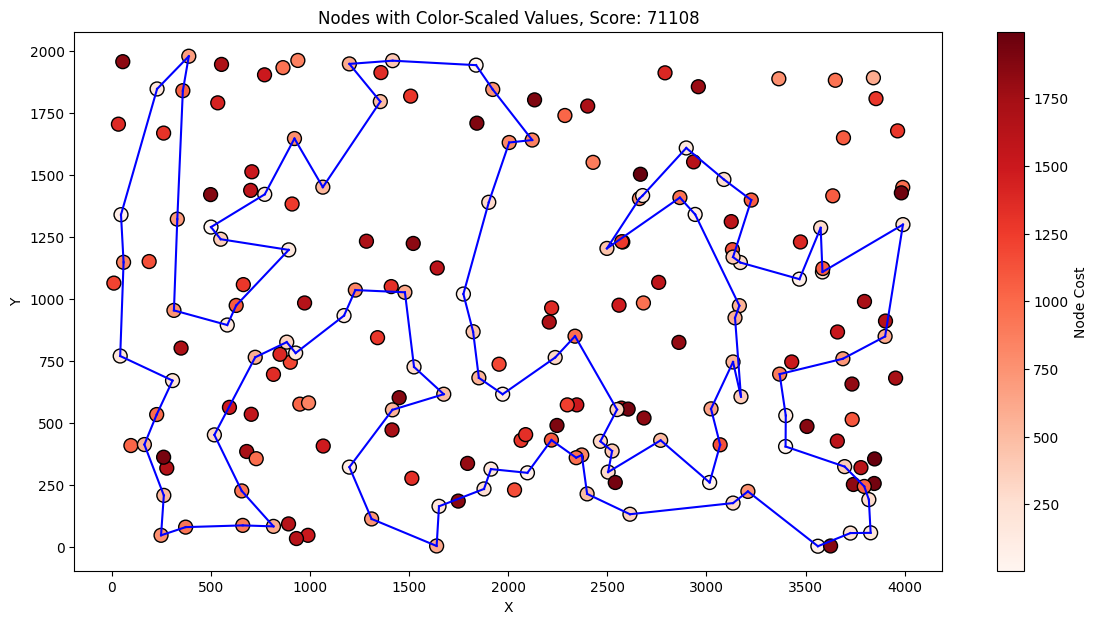

Plotting Node: 0


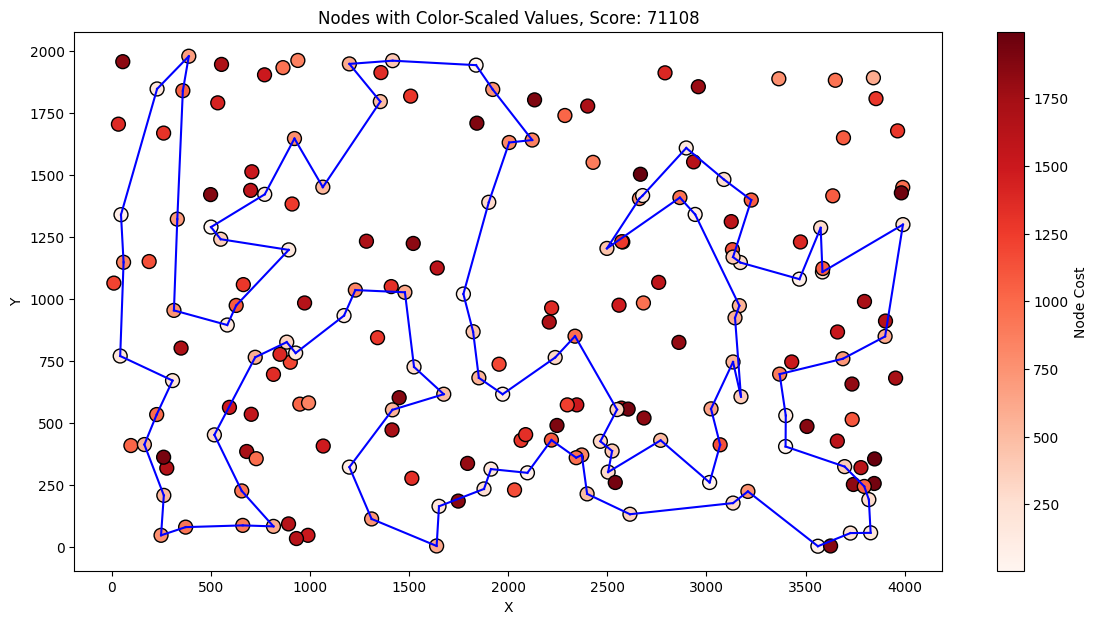

___________________________________________________________________
For Node: 56


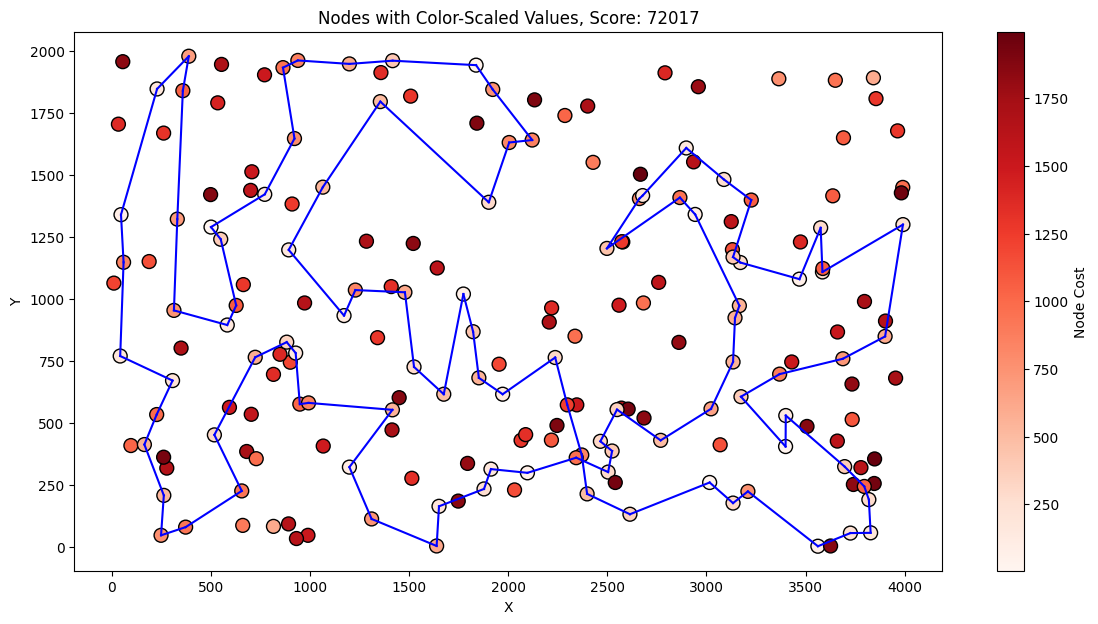

___________________________________________________________________
For Node: 125


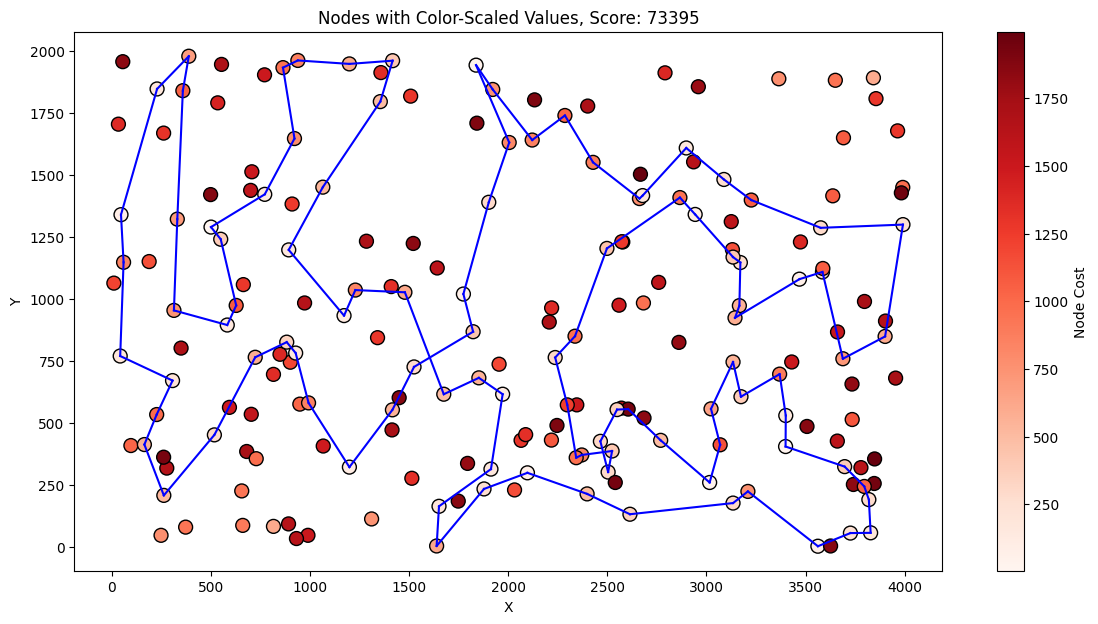

Overall Stats: 
 Minimum: 71108 Maximum: 73395 Median: 72017.0 Mean: 72132.785 Standard Deviation: 497.798803509008


In [23]:
plot_score_distribution_not_random(weighted_cycle_results_A, label="NN All")
plot_best_overall_not_random(df_A, weighted_cycle_solutions_A, weighted_cycle_results_A)
plot_node(df_A, weighted_cycle_results_A, weighted_cycle_solutions_A, node=0)
plot_average_overall_not_random(df_A, weighted_cycle_solutions_A, weighted_cycle_results_A)
plot_worst_overall_not_random(df_A, weighted_cycle_solutions_A, weighted_cycle_results_A)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(weighted_cycle_results_A)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

## Results - Instance B

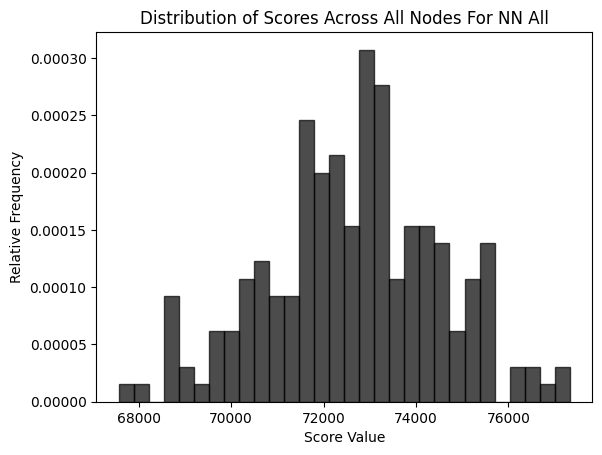

___________________________________________________________________
For Node: 60


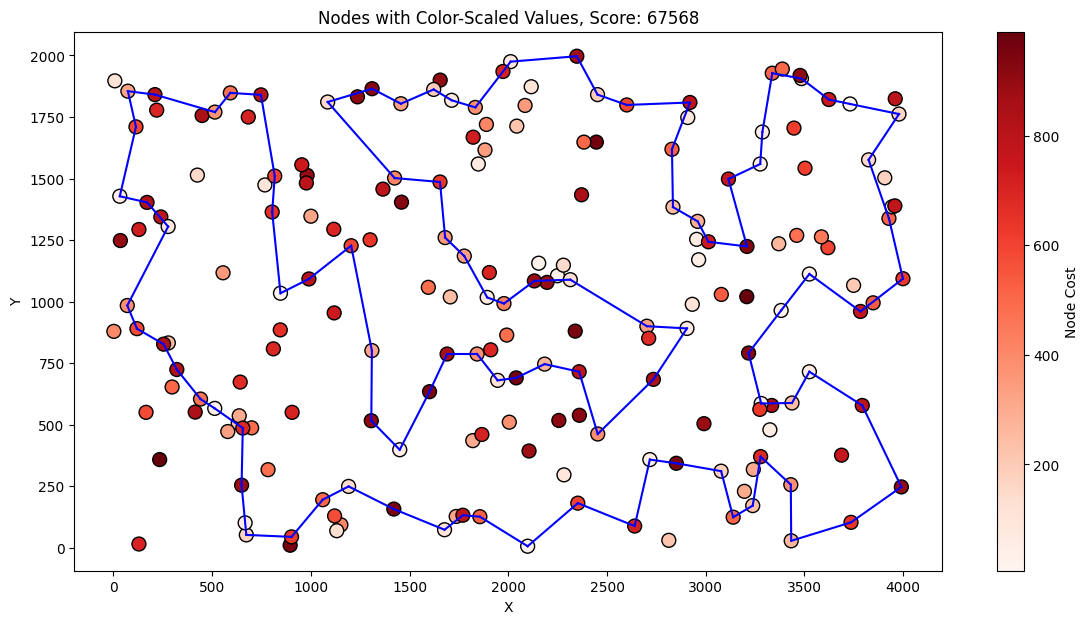

Plotting Node: 0


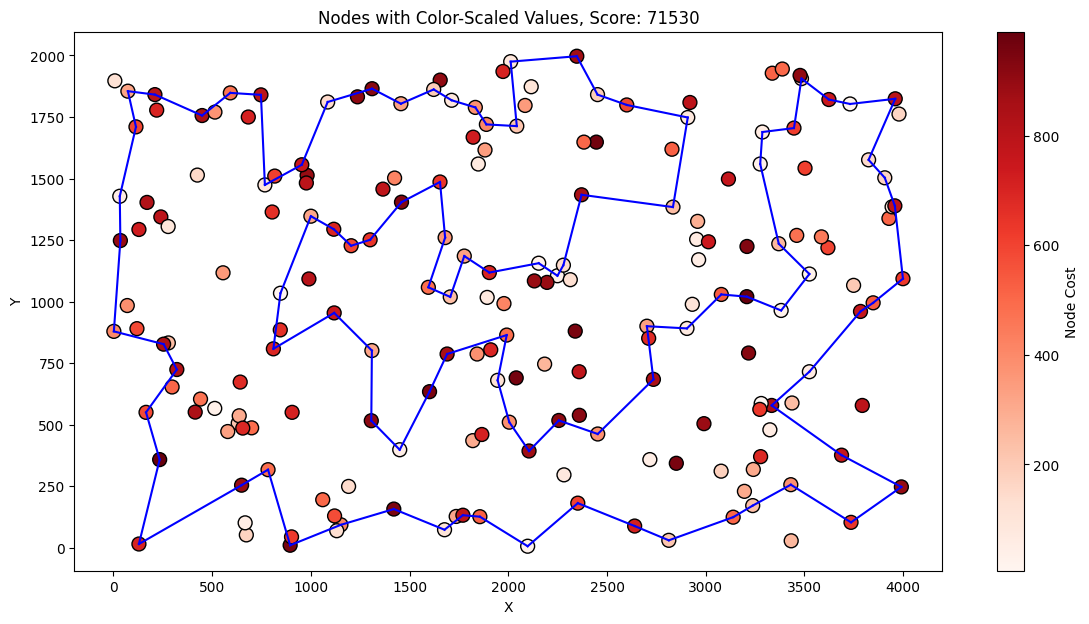

___________________________________________________________________
For Node: 180


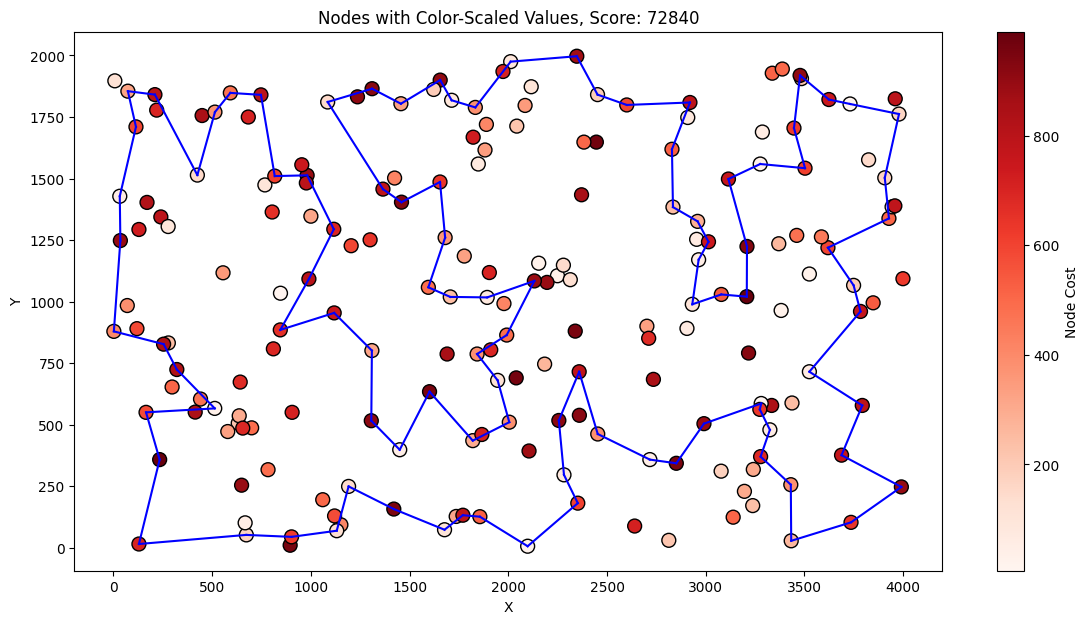

___________________________________________________________________
For Node: 2


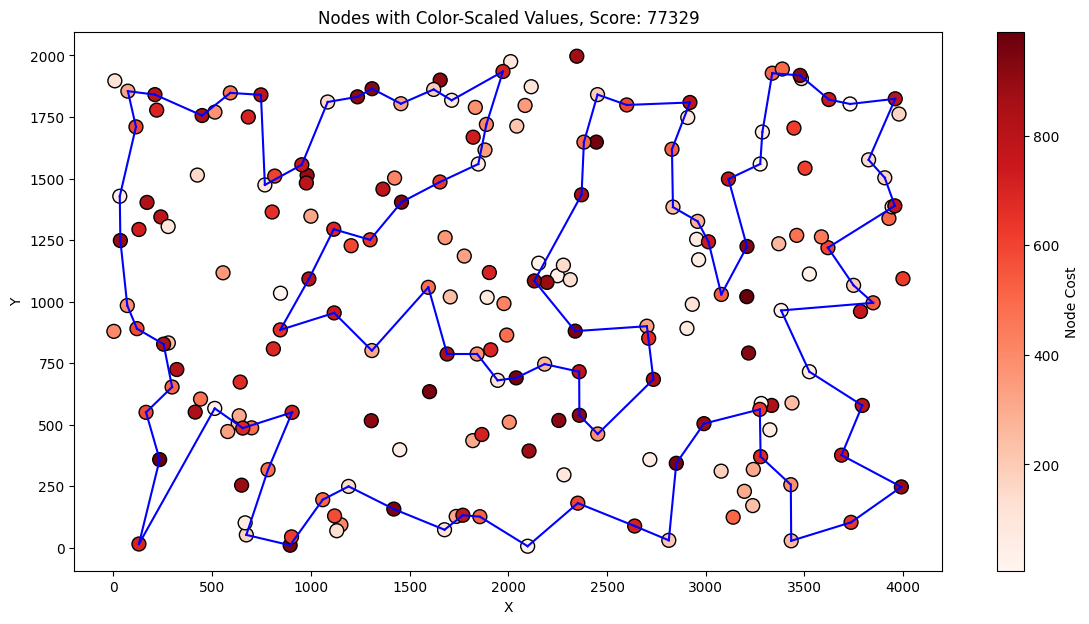

Overall Stats: 
 Minimum: 67568 Maximum: 77329 Median: 72807.0 Mean: 72656.19 Standard Deviation: 1884.5316935249457


In [24]:
plot_score_distribution_not_random(greedy_regret_cycle_results_B, label="NN All")
plot_best_overall_not_random(df_B, greedy_regret_cycle_solutions_B, greedy_regret_cycle_results_B)
plot_node(df_B, greedy_regret_cycle_results_B, greedy_regret_cycle_solutions_B, node=0)
plot_average_overall_not_random(df_B, greedy_regret_cycle_solutions_B, greedy_regret_cycle_results_B)
plot_worst_overall_not_random(df_B, greedy_regret_cycle_solutions_B, greedy_regret_cycle_results_B)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(greedy_regret_cycle_results_B)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

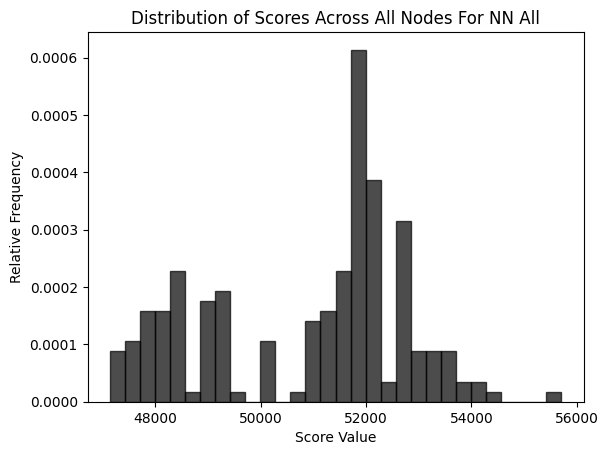

___________________________________________________________________
For Node: 199


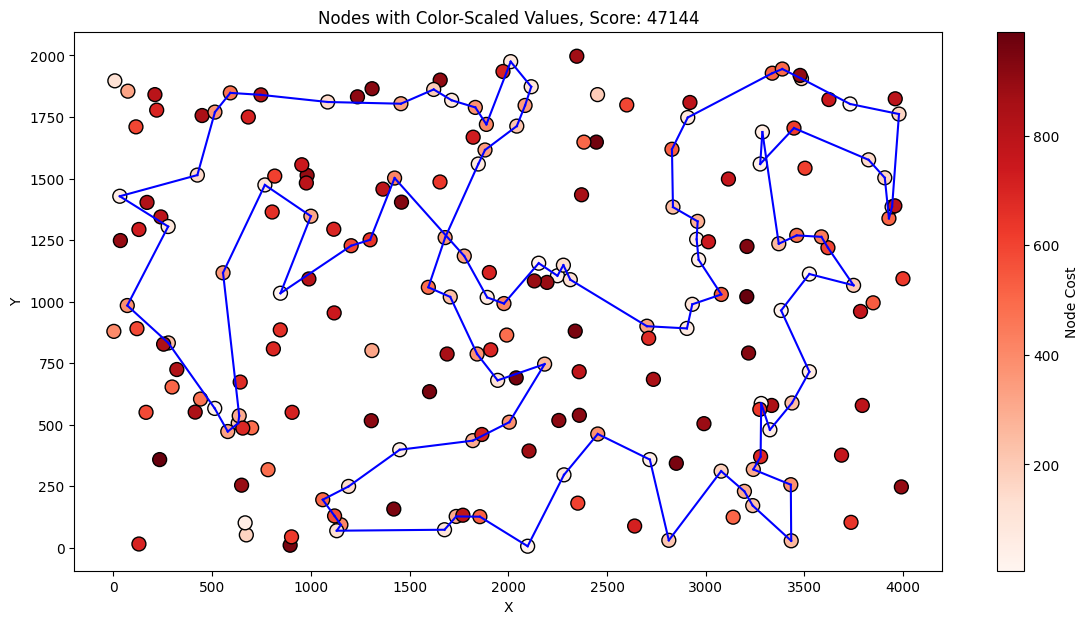

Plotting Node: 0


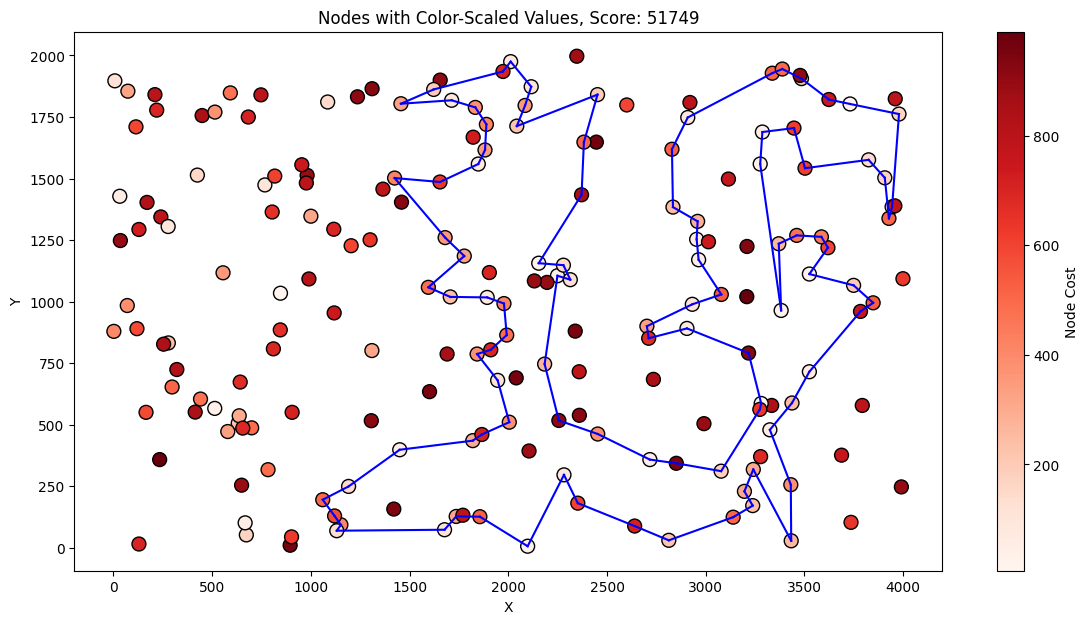

___________________________________________________________________
For Node: 26


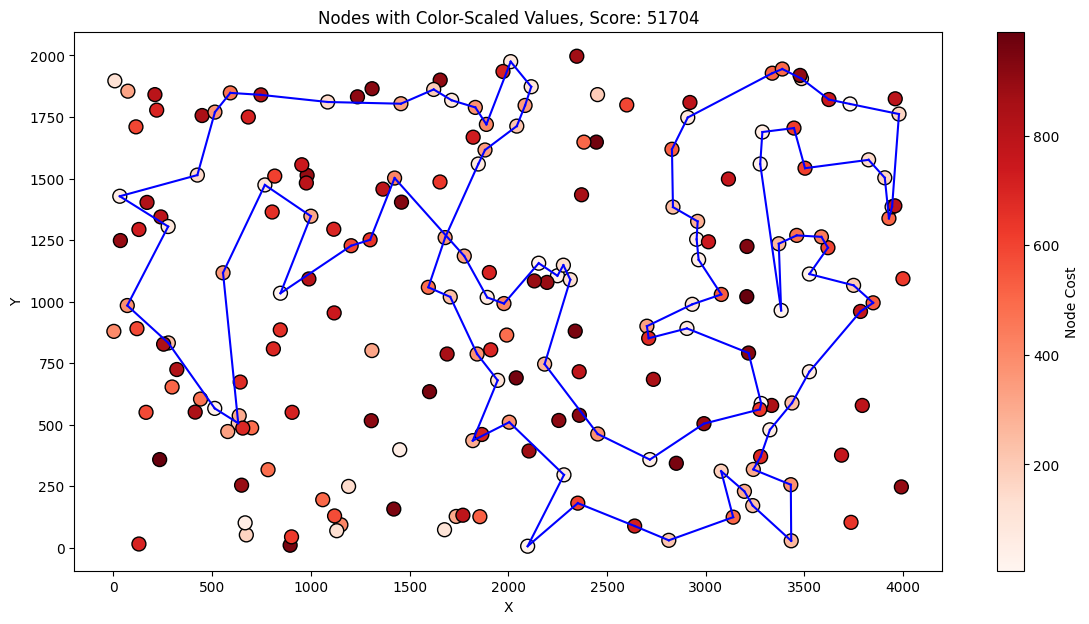

___________________________________________________________________
For Node: 56


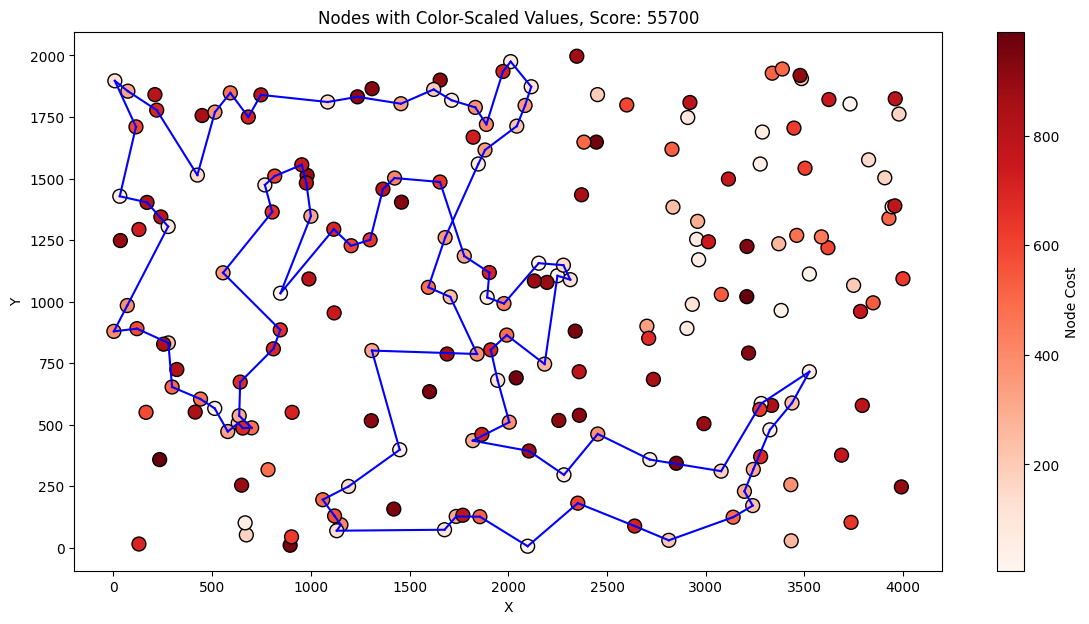

Overall Stats: 
 Minimum: 47144 Maximum: 55700 Median: 51704.0 Mean: 50882.28 Standard Deviation: 1902.2385317304452


In [25]:
plot_score_distribution_not_random(weighted_cycle_results_B, label="NN All")
plot_best_overall_not_random(df_B, weighted_cycle_solutions_B, weighted_cycle_results_B)
plot_node(df_B, weighted_cycle_results_B, weighted_cycle_solutions_B, node=0)
plot_average_overall_not_random(df_B, weighted_cycle_solutions_B, weighted_cycle_results_B)
plot_worst_overall_not_random(df_B, weighted_cycle_solutions_B, weighted_cycle_results_B)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(weighted_cycle_results_B)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

### All

In [26]:
comparison_regret, comparison_weighted, total_results  = summarize_results(greedy_regret_cycle_results_B, weighted_cycle_results_B)
comparison_regret

0        1        2        3        4        5        6    \
Best Score:    71530.0  70399.0  77329.0  72901.0  74569.0  74241.0  71705.0   
Worst Score:   71530.0  70399.0  77329.0  72901.0  74569.0  74241.0  71705.0   
Median Score:  71530.0  70399.0  77329.0  72901.0  74569.0  74241.0  71705.0   
Average Score  71530.0  70399.0  77329.0  72901.0  74569.0  74241.0  71705.0   

                   7        8        9    ...      190      191      192  \
Best Score:    76814.0  72899.0  74857.0  ...  72640.0  71411.0  73390.0   
Worst Score:   76814.0  72899.0  74857.0  ...  72640.0  71411.0  73390.0   
Median Score:  76814.0  72899.0  74857.0  ...  72640.0  71411.0  73390.0   
Average Score  76814.0  72899.0  74857.0  ...  72640.0  71411.0  73390.0   

                   193      194      195      196      197      198      199  
Best Score:    69779.0  73207.0  72321.0  70797.0  75500.0  72224.0  74862.0  
Worst Score:   69779.0  73207.0  72321.0  70797.0  75500.0  72224.0  74862.0  
Median Score:  69779.0  73207.0  72321.0  70797.0  75500.0  72224.0  74862.0  
Average Score  69779.0  73207.0  72321.0  70797.0  75500.0  72224.0  74862.0  

[4 rows x 200 columns]

In [27]:
comparison_weighted

0        1        2        3        4        5        6    \
Best Score:    51749.0  52023.0  49288.0  50083.0  47550.0  52253.0  49084.0   
Worst Score:   51749.0  52023.0  49288.0  50083.0  47550.0  52253.0  49084.0   
Median Score:  51749.0  52023.0  49288.0  50083.0  47550.0  52253.0  49084.0   
Average Score  51749.0  52023.0  49288.0  50083.0  47550.0  52253.0  49084.0   

                   7        8        9    ...      190      191      192  \
Best Score:    53033.0  49421.0  47424.0  ...  51578.0  52137.0  51958.0   
Worst Score:   53033.0  49421.0  47424.0  ...  51578.0  52137.0  51958.0   
Median Score:  53033.0  49421.0  47424.0  ...  51578.0  52137.0  51958.0   
Average Score  53033.0  49421.0  47424.0  ...  51578.0  52137.0  51958.0   

                   193      194      195      196      197      198      199  
Best Score:    51681.0  48299.0  49084.0  53494.0  52687.0  52023.0  47144.0  
Worst Score:   51681.0  48299.0  49084.0  53494.0  52687.0  52023.0  47144.0  
Median Score:  51681.0  48299.0  49084.0  53494.0  52687.0  52023.0  47144.0  
Average Score  51681.0  48299.0  49084.0  53494.0  52687.0  52023.0  47144.0  

[4 rows x 200 columns]

In [28]:
total_results

0                1                2    \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                3                4                5    \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                6                7                8    \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                9    ...              190              191  \
Best Maximum Score  Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   

                                192              193              194  \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                195              196              197  \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                198              199  
Best Maximum Score  Weighted Greedy  Weighted Greedy  
Best Minimum Score  Weighted Greedy  Weighted Greedy  
Best Average Score  Weighted Greedy  Weighted Greedy  
Best Median Score   Weighted Greedy  Weighted Greedy  

[4 rows x 200 columns]

In [29]:
total_results

0                1                2    \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                3                4                5    \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                6                7                8    \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                9    ...              190              191  \
Best Maximum Score  Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  ...  Weighted Greedy  Weighted Greedy   

                                192              193              194  \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                195              196              197  \
Best Maximum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Minimum Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Average Score  Weighted Greedy  Weighted Greedy  Weighted Greedy   
Best Median Score   Weighted Greedy  Weighted Greedy  Weighted Greedy   

                                198              199  
Best Maximum Score  Weighted Greedy  Weighted Greedy  
Best Minimum Score  Weighted Greedy  Weighted Greedy  
Best Average Score  Weighted Greedy  Weighted Greedy  
Best Median Score   Weighted Greedy  Weighted Greedy  

[4 rows x 200 columns]

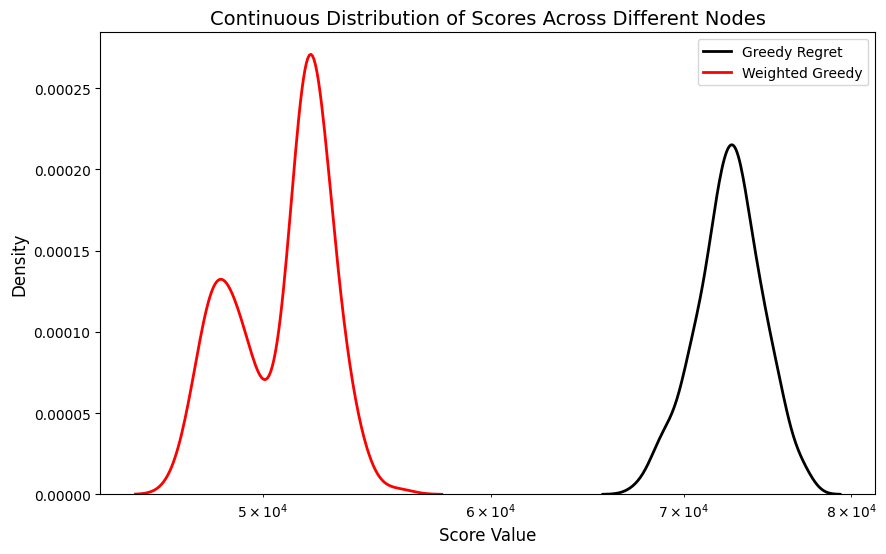

In [30]:
plot_score_distributions(greedy_regret_cycle_results_B, weighted_cycle_results_B, ["Greedy Regret", "Weighted Greedy"])

## Comparing Both Instances

In [31]:
def plot_all_distributions(score_dict_1, score_dict_2, score_dict_3, score_dict_4):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)

    all_scores_3 = []
    for key in score_dict_3.keys():
        item = score_dict_3[key]
        all_scores_3.append(item)

    all_scores_4 = []
    for key in score_dict_4.keys():
        item = score_dict_4[key]
        all_scores_4.append(item)
    
    plt.figure(figsize=(18, 12))

    all_scores_1 = np.array(all_scores_1)
    all_scores_2 = np.array(all_scores_2)
    all_scores_3 = np.array(all_scores_3)
    all_scores_4 = np.array(all_scores_4)

    to_plot = [np.mean(all_scores_1), np.mean(all_scores_2), np.mean(all_scores_3), np.mean(all_scores_4)]
    labels = ["Greedy Regret A", "Weighted Greedy A", "Greedy Regret B", "Weighted Greedy B"]
    sorted_indices = np.argsort(to_plot)[::-1]
    to_plot_sorted = np.array(to_plot)[sorted_indices]
    labels_sorted = np.array(labels)[sorted_indices]

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.yscale('log')
    plt.bar(labels_sorted, to_plot_sorted, color=['blue', 'red', 'green', 'black'])

    # Adding title and labels
    plt.title('Comparison of Mean Scores Across Different TSP Algorithms', fontsize=14)
    plt.xlabel('TSP Algorithms', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean Score Logarithmic Scale)', fontsize=12)

<Figure size 1800x1200 with 0 Axes>

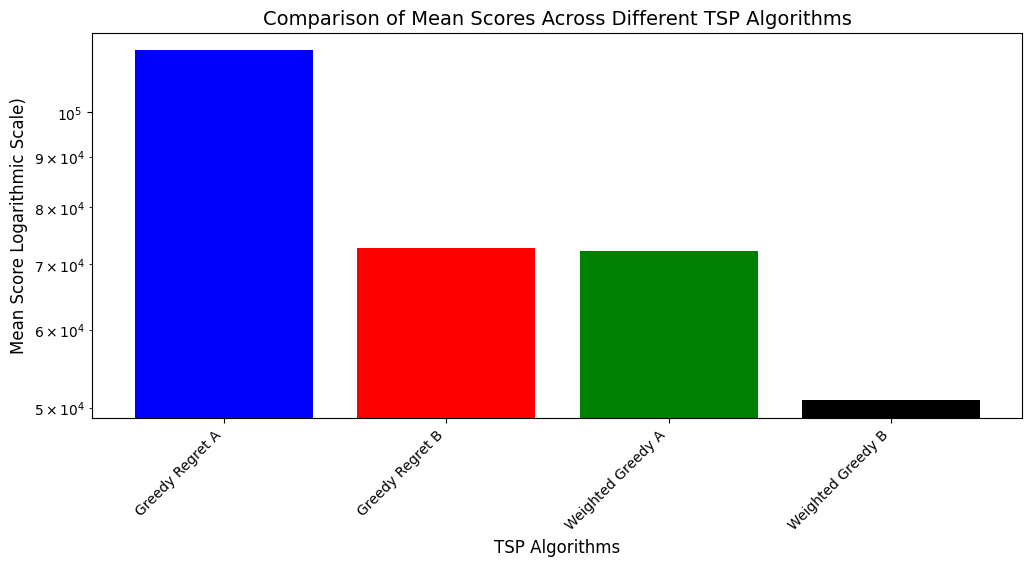

In [32]:
plot_all_distributions(greedy_regret_cycle_results_A, weighted_cycle_results_A, greedy_regret_cycle_results_B, weighted_cycle_results_B)

### Best Solutions Nodes

In [39]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()

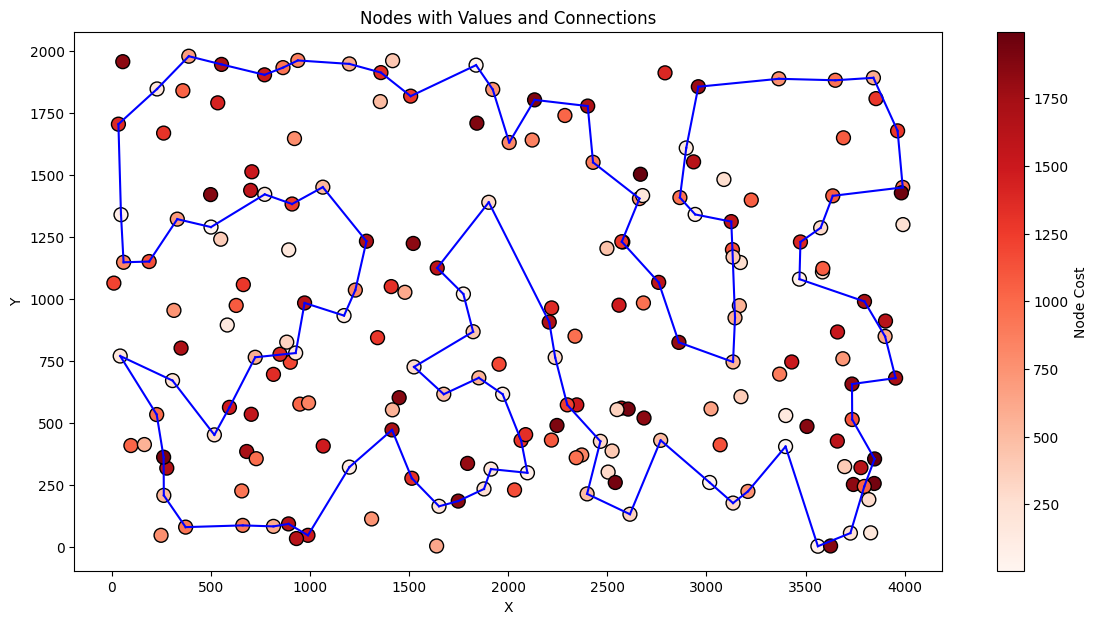

Acheived Total Score: 105852
[159, 195, 146, 22, 20, 18, 108, 67, 36, 140, 93, 117, 170, 153, 183, 89, 23, 83, 64, 15, 9, 37, 128, 172, 57, 55, 3, 32, 49, 102, 144, 132, 21, 7, 164, 71, 27, 39, 165, 8, 185, 174, 81, 98, 17, 157, 188, 56, 171, 16, 78, 25, 44, 120, 2, 75, 86, 97, 189, 94, 130, 137, 66, 176, 80, 151, 133, 79, 63, 136, 53, 180, 154, 6, 135, 194, 161, 123, 29, 126, 112, 4, 190, 177, 147, 48, 34, 160, 184, 28, 43, 65, 197, 59, 118, 60, 46, 198, 139, 193]


In [40]:
start_node = 93
solution, score = greedy_regret_cycle(distance_matrix, weights_A, start_node)
plot_nodes_with_lines(df_A, solution)
print(f"Acheived Total Score: {score}")
print(solution)

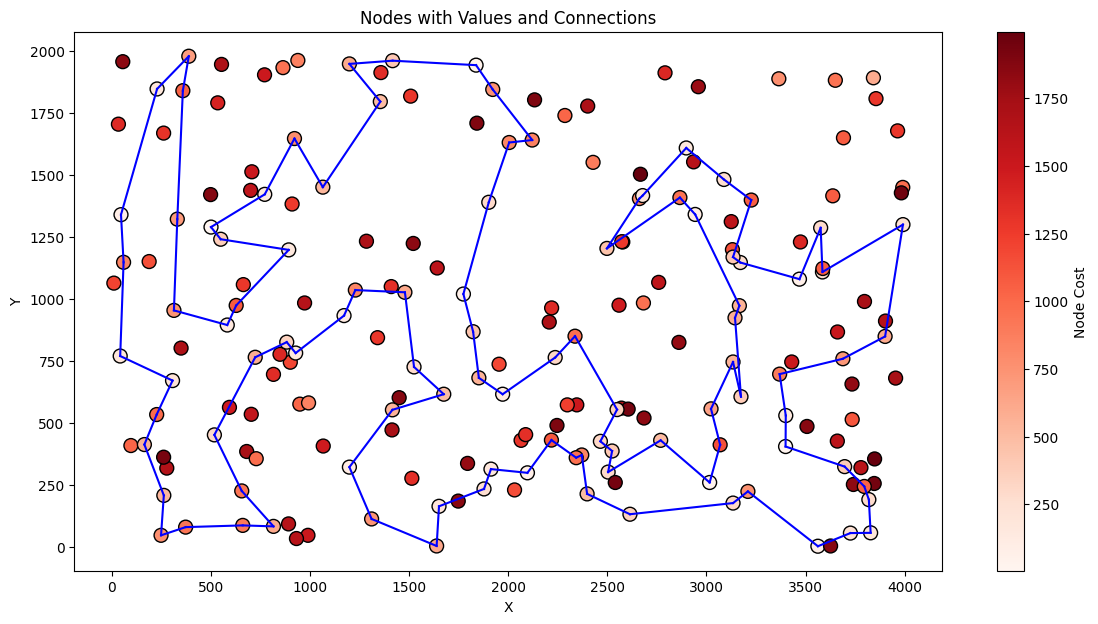

Acheived Total Score: 71108
[117, 0, 46, 68, 139, 193, 41, 115, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 90, 40, 165, 185, 106, 178, 138, 14, 144, 62, 9, 148, 102, 49, 52, 55, 92, 57, 129, 82, 120, 2, 101, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143]


In [41]:
start_node = 0
solution, score = greedy_regret_cycle_weighted(distance_matrix, weights_A, start_node)
plot_nodes_with_lines(df_A, solution)
print(f"Acheived Total Score: {score}")
print(solution)

In [42]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()

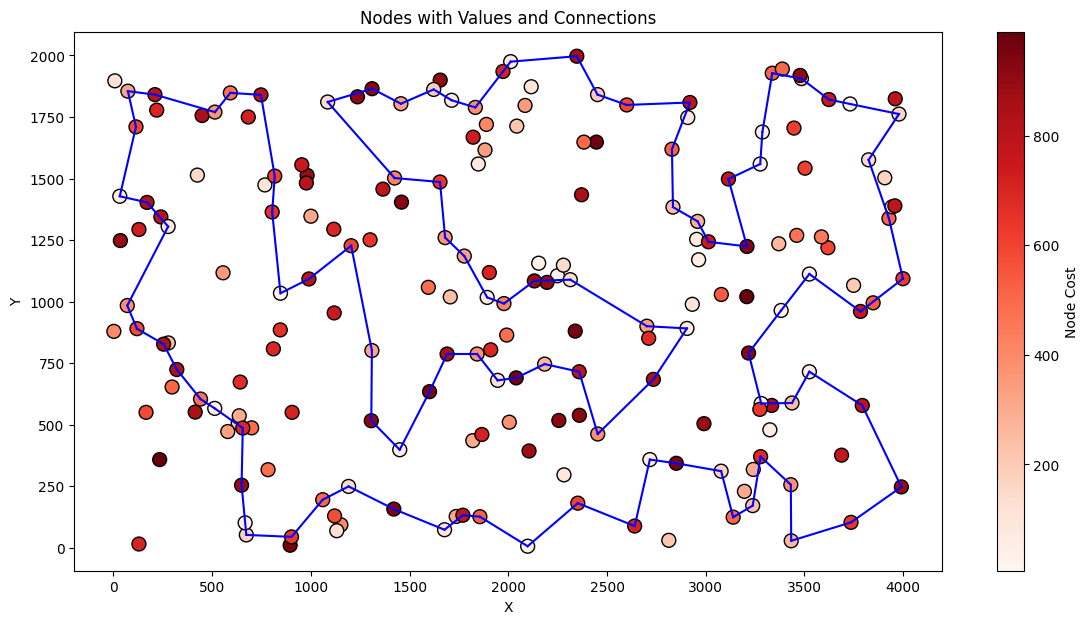

Acheived Total Score: 67568
[60, 20, 59, 28, 4, 140, 183, 174, 181, 83, 55, 34, 170, 53, 184, 155, 84, 70, 132, 169, 188, 6, 150, 147, 134, 43, 139, 11, 33, 160, 39, 35, 143, 106, 119, 81, 41, 111, 68, 8, 104, 157, 171, 177, 123, 25, 118, 116, 121, 125, 191, 115, 10, 133, 17, 107, 100, 63, 96, 135, 38, 16, 197, 24, 198, 117, 164, 105, 80, 162, 45, 5, 7, 36, 79, 91, 141, 97, 146, 153, 186, 163, 165, 127, 26, 114, 137, 75, 93, 48, 166, 194, 176, 64, 86, 185, 52, 57, 66, 148]


In [45]:
start_node = 60
solution, score = greedy_regret_cycle(distance_matrix, weights_B, start_node)
plot_nodes_with_lines(df_B, solution)
print(f"Acheived Total Score: {score}")
print(solution)

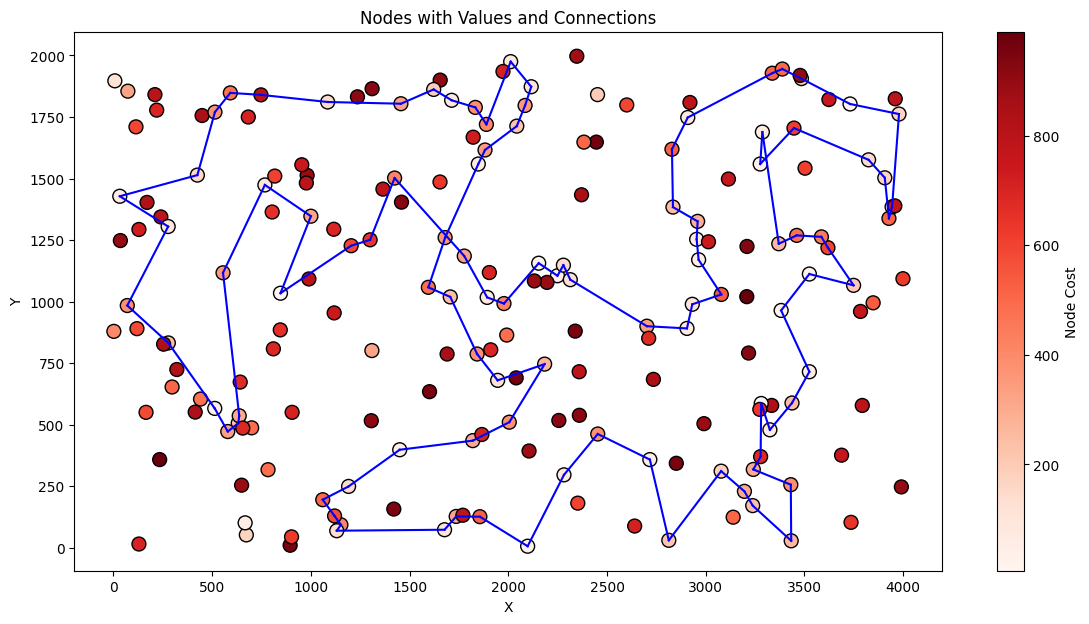

Acheived Total Score: 47144
[95, 130, 99, 22, 179, 185, 86, 166, 194, 113, 176, 26, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 175, 78, 142, 45, 5, 177, 21, 82, 111, 8, 104, 138, 182, 139, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 147, 115, 10, 133, 122, 63, 135, 38, 1, 117, 193, 31, 54, 131, 90, 51, 121, 118, 74, 134, 11, 33, 160, 29, 0, 109, 35, 143, 106, 124, 128, 62, 18, 55, 34, 170, 152, 4, 149, 28, 20, 60, 94, 66, 47, 148, 199, 183, 140]


In [44]:
start_node = 199
solution, score = greedy_regret_cycle_weighted(distance_matrix, weights_B, start_node)
plot_nodes_with_lines(df_B, solution)
print(f"Acheived Total Score: {score}")
print(solution)